In [371]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Cleaning & Preprocessing

In [372]:
df = pd.read_csv("all_waybill_info_meituan_0322.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654343 entries, 0 to 654342
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   Unnamed: 0                  654343 non-null  int64
 1   dt                          654343 non-null  int64
 2   order_id                    654343 non-null  int64
 3   waybill_id                  654343 non-null  int64
 4   courier_id                  654343 non-null  int64
 5   da_id                       654343 non-null  int64
 6   is_courier_grabbed          654343 non-null  int64
 7   is_weekend                  654343 non-null  int64
 8   estimate_arrived_time       654343 non-null  int64
 9   is_prebook                  654343 non-null  int64
 10  poi_id                      654343 non-null  int64
 11  sender_lng                  654343 non-null  int64
 12  sender_lat                  654343 non-null  int64
 13  recipient_lng               654343 non-null 

In [373]:
print("Null values per column:")
print(df.isnull().sum())

Null values per column:
Unnamed: 0                    0
dt                            0
order_id                      0
waybill_id                    0
courier_id                    0
da_id                         0
is_courier_grabbed            0
is_weekend                    0
estimate_arrived_time         0
is_prebook                    0
poi_id                        0
sender_lng                    0
sender_lat                    0
recipient_lng                 0
recipient_lat                 0
grab_lng                      0
grab_lat                      0
dispatch_time                 0
grab_time                     0
fetch_time                    0
arrive_time                   0
estimate_meal_prepare_time    0
order_push_time               0
platform_order_time           0
dtype: int64


### Convert time fields from UNIX 

In [374]:
df["dt"] = pd.to_datetime(df["dt"], format="%Y%m%d")
df["dispatch_time"] = pd.to_datetime(df["dispatch_time"], unit="s",errors="coerce")
df["grab_time"] = pd.to_datetime(df["grab_time"], unit="s",errors="coerce")
df["fetch_time"] = pd.to_datetime(df["fetch_time"], unit="s",errors="coerce")
df["arrive_time"]  = pd.to_datetime(df["arrive_time"], unit="s",errors="coerce")
df["estimate_meal_prepare_time"]  = pd.to_datetime(df["estimate_meal_prepare_time"], unit="s",errors="coerce")
df["estimate_arrived_time"]  = pd.to_datetime(df["estimate_arrived_time"], unit="s",errors="coerce")
df["order_push_time"]  = pd.to_datetime(df["order_push_time"], unit="s",errors="coerce")
df["platform_order_time"]  = pd.to_datetime(df["platform_order_time"], unit="s",errors="coerce")

In [375]:
df["arrive_time"]

0        1970-01-01 00:00:00
1        2022-10-16 16:29:58
2        2022-10-16 16:56:24
3        2022-10-16 17:03:42
4        2022-10-16 16:37:42
                 ...        
654338   1970-01-01 00:00:00
654339   2022-10-24 15:18:09
654340   2022-10-24 15:59:32
654341   2022-10-24 16:16:37
654342   2022-10-24 16:30:32
Name: arrive_time, Length: 654343, dtype: datetime64[ns]

### Check for incorrect times

In [376]:
accepted_df=df.copy()
accepted_df = accepted_df[accepted_df["is_courier_grabbed"] == 1]
(accepted_df == "1970-01-01 00:00:00").any()


Unnamed: 0                    False
dt                            False
order_id                      False
waybill_id                    False
courier_id                    False
da_id                         False
is_courier_grabbed            False
is_weekend                    False
estimate_arrived_time         False
is_prebook                    False
poi_id                        False
sender_lng                    False
sender_lat                    False
recipient_lng                 False
recipient_lat                 False
grab_lng                      False
grab_lat                      False
dispatch_time                  True
grab_time                     False
fetch_time                    False
arrive_time                    True
estimate_meal_prepare_time     True
order_push_time               False
platform_order_time           False
dtype: bool

In [377]:
zero_ts = pd.to_datetime(0, unit="s")  # 1970-01-01 00:00:00

counts = {}
for col in ["dispatch_time", "fetch_time", "estimate_meal_prepare_time"]:
    counts[col] = (accepted_df[col] == zero_ts).sum()

print(counts)

{'dispatch_time': 1, 'fetch_time': 0, 'estimate_meal_prepare_time': 9874}


In [378]:
bad_order_id = accepted_df[(accepted_df["dispatch_time"] == zero_ts) | (accepted_df["fetch_time"] == zero_ts)
]["order_id"]

print(bad_order_id.tolist())


[26520]


In [379]:
accepted_df = accepted_df[accepted_df["order_id"] != 225004]

## **Courier Fairness Analysis**

### Workload analysis in terms of number of daily orders 

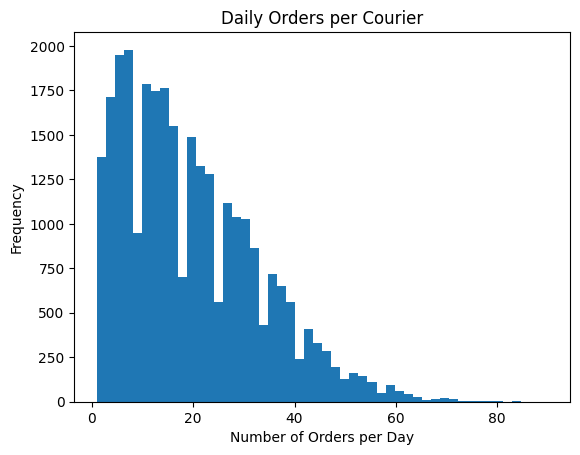

In [380]:
# Daily orders per courier
daily_orders = (
    accepted_df.groupby(["dt", "courier_id"])["order_id"]
    .nunique()
    .reset_index(name="order_count")
)
# Distribution of daily orders per courier (across all days)
daily_orders["order_count"].plot(
    kind="hist", bins=50, title="Daily Orders per Courier"
)
plt.xlabel("Number of Orders per Day")
plt.ylabel("Frequency")
plt.show()


In [381]:
daily_orders.head()

,dt,courier_id,order_count
0,2022-10-17,0,2
1,2022-10-17,1,6
2,2022-10-17,2,22
3,2022-10-17,3,9
4,2022-10-17,4,42


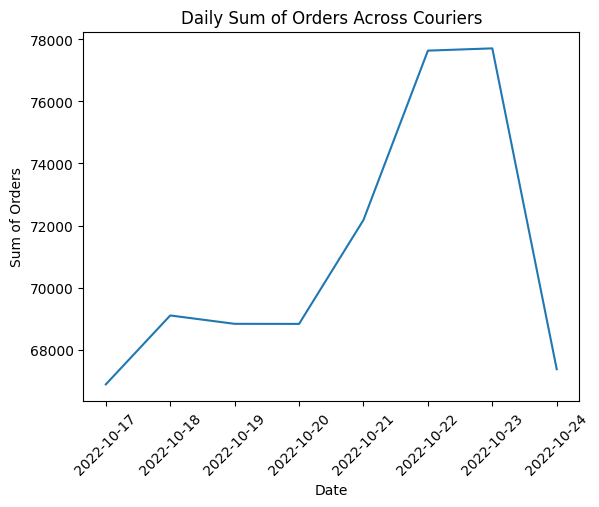

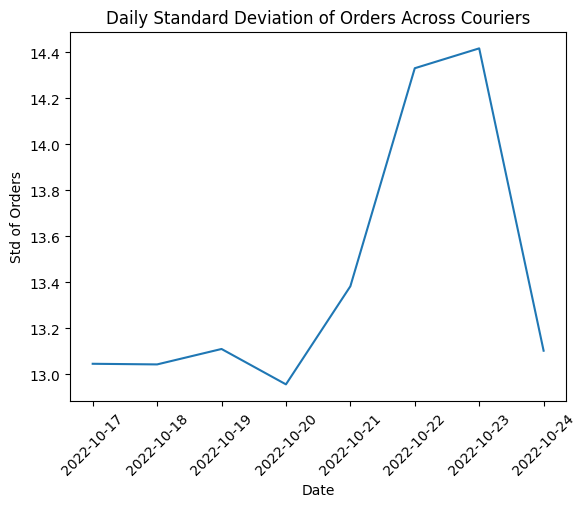

In [382]:
# Mean and standard deviation across couriers per day
daily_stats = daily_orders.groupby("dt")["order_count"].agg(["mean", "std","sum"])

# Plot sum
plt.plot(daily_stats.index, daily_stats["sum"])
plt.title("Daily Sum of Orders Across Couriers")
plt.xlabel("Date")
plt.ylabel("Sum of Orders")
plt.xticks(rotation=45)
plt.show()

# Plot std
plt.plot(daily_stats.index, daily_stats["std"])
plt.title("Daily Standard Deviation of Orders Across Couriers")
plt.xlabel("Date")
plt.ylabel("Std of Orders")
plt.xticks(rotation=45)
plt.show()


In [383]:
print("Average mean orders per courier per day:", daily_stats["mean"].mean())
print("Average std across days:", daily_stats["std"].mean())
print("Max std on a single day:", daily_stats["std"].max())

Average mean orders per courier per day: 19.66135232619036
Average std across days: 13.42421062753594
Max std on a single day: 14.417655873689654


### Exploring the relation between workload and order rejection 

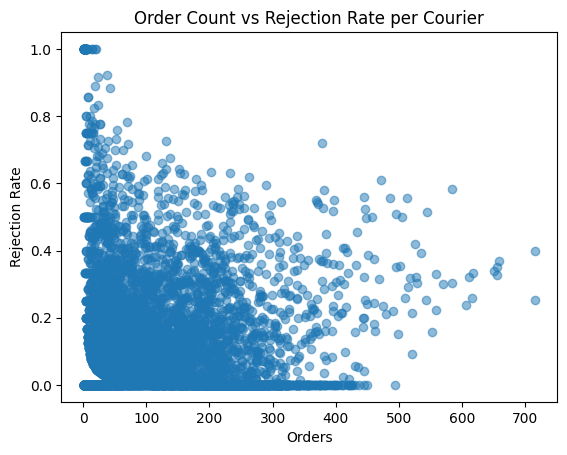

                  orders  rejections  rejection_rate
orders          1.000000    0.490220       -0.141485
rejections      0.490220    1.000000        0.483594
rejection_rate -0.141485    0.483594        1.000000


In [384]:
courier_stats = df.groupby("courier_id").agg(
    orders=("order_id", "nunique"),
    rejections=("is_courier_grabbed", lambda x: (x==0).sum())
)
courier_stats["rejection_rate"] = courier_stats["rejections"] / courier_stats["orders"]

plt.scatter(courier_stats["orders"], courier_stats["rejection_rate"], alpha=0.5)
plt.title("Order Count vs Rejection Rate per Courier")
plt.xlabel("Orders")
plt.ylabel("Rejection Rate")
plt.show()

print(courier_stats.corr())

**Comments:** 
* Some couriers seem overloaded with many orders but reject less (so they carry the business).

* Many couriers get only a few orders but reject a lot (implying  inefficiency & lack of engagement)

### Measuring equality of accepted orders distribution amongst couriers

Gini coefficient (orders per courier): 0.44431793821167453


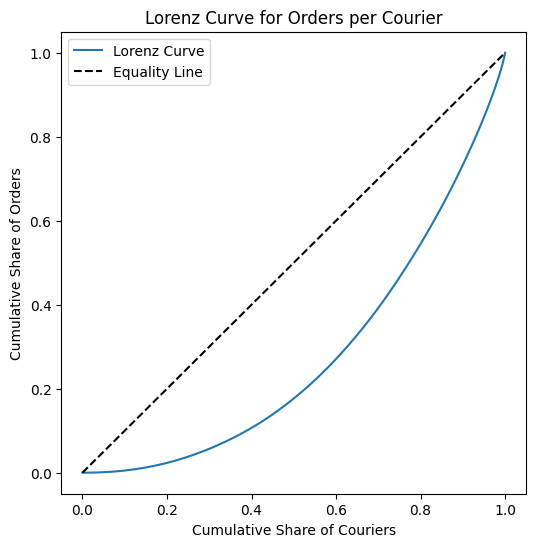

In [385]:

# Get orders per courier
orders = courier_stats["orders"].values

# --- Function to compute Gini coefficient ---
def gini_coefficient(x):
    x = np.sort(x)  # sort values
    n = len(x)
    cumx = np.cumsum(x)
    gini = (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n
    return gini

# Compute Gini
gini_value = gini_coefficient(orders)
print("Gini coefficient (orders per courier):", gini_value)

# --- Lorenz curve ---
sorted_orders = np.sort(orders)
cum_orders = np.cumsum(sorted_orders) / sorted_orders.sum()
cum_couriers = np.arange(1, len(sorted_orders) + 1) / len(sorted_orders)

plt.figure(figsize=(6,6))
plt.plot(cum_couriers, cum_orders, label="Lorenz Curve")
plt.plot([0,1], [0,1], linestyle="--", color="black", label="Equality Line")
plt.title("Lorenz Curve for Orders per Courier")
plt.xlabel("Cumulative Share of Couriers")
plt.ylabel("Cumulative Share of Orders")
plt.legend()
plt.show()

**Comments:**

* Most active 20% complete over 40% of orders

* Least active 50% complete less than 20% of orders

### Workload analysis in terms of number of trip duration 

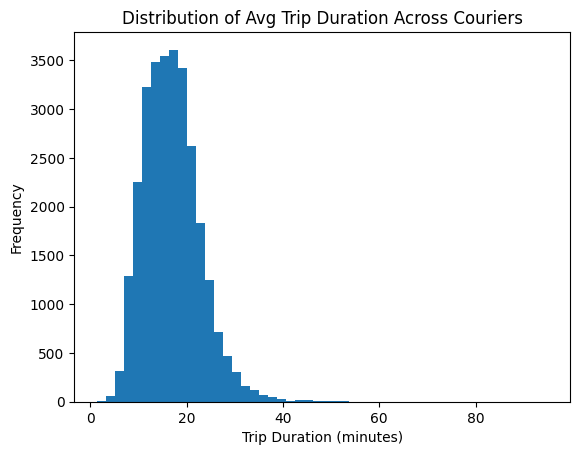

Mean of trip duration between couriers: 16.985802648429605
Std of avg trip duration between couriers: 5.893802122398401


In [386]:

# --- 2. Create trip_duration in minutes ---
accepted_df["trip_duration"] = (accepted_df["arrive_time"] - accepted_df["fetch_time"]).dt.total_seconds() / 60

# --- 4. Group by courier and compute stats ---
trip_stats = accepted_df.groupby(["courier_id","dt"])["trip_duration"].agg(
    mean="mean",
    std="std")

# --- 5. Plot histogram of average trip durations across couriers ---
trip_stats["mean"].plot(
    kind="hist",
    bins=50,
    title="Distribution of Avg Trip Duration Across Couriers"
)
plt.xlabel("Trip Duration (minutes)")
plt.show()

# --- 6. Print dispersion across couriers ---
print("Mean of trip duration between couriers:", trip_stats["mean"].mean())
print("Std of avg trip duration between couriers:", trip_stats["mean"].std())


In [411]:
# --- 2. Determine threshold for longest 10% ---
threshold = np.percentile(accepted_df["trip_duration"], 90)  # top 10% cutoff

# --- 3. Filter the longest 10% of orders ---
long_orders = accepted_df[accepted_df["trip_duration"] >= threshold]

print(f"Threshold for longest 10% of orders: {threshold:.2f} minutes")
print(f"Number of orders in longest 10%: {len(long_orders)}")

# --- 4. Get all couriers ---
all_couriers = accepted_df["courier_id"].unique()
num_all_couriers = len(all_couriers)

# --- 5. Count long orders per courier, fill 0 for couriers with none ---
courier_counts = long_orders.groupby("courier_id").size()
courier_counts = courier_counts.reindex(all_couriers, fill_value=0)

print(f"Number of couriers delivering longest 10% orders: {(courier_counts>0).sum()}")
print(f"Percentage of total couriers who delivering longest 10% orders: {(((courier_counts>0).sum())/df["courier_id"].nunique())*100}")

# --- 6. Compute Gini across all couriers ---
def gini(x):
    x = np.array(x, dtype=float)
    x = x.flatten()
    if np.amin(x) < 0:
        x -= np.amin(x)
    x += 1e-10  # avoid divide by zero
    x = np.sort(x)
    n = len(x)
    index = np.arange(1, n+1)
    return ((np.sum((2*index - n - 1) * x)) / (n * np.sum(x)))

gini_index = gini(courier_counts)
print(f"Gini coefficient of long order distribution across all couriers: {gini_index:.3f}")

# --- 7. Sort couriers by number of long orders ---
courier_counts_sorted = courier_counts.sort_values(ascending=False)

# --- 8. Top 10% couriers by long orders ---
top_10pct_count = max(1, int(0.1 * num_all_couriers))  # at least 1 courier
top_couriers = courier_counts_sorted.head(top_10pct_count)



Threshold for longest 10% of orders: 27.87 minutes
Number of orders in longest 10%: 18798
Number of couriers delivering longest 10% orders: 3678
Percentage of total couriers who delivering longest 10% orders: 74.22805247225025
Gini coefficient of long order distribution across all couriers: 0.584


### Workload analysis in terms of courier idle times 

count    27286.000000
mean        55.611001
std         72.624370
min          0.000000
25%         18.231270
50%         35.091667
75%         65.394965
max       1362.283333
Name: idle_time, dtype: float64


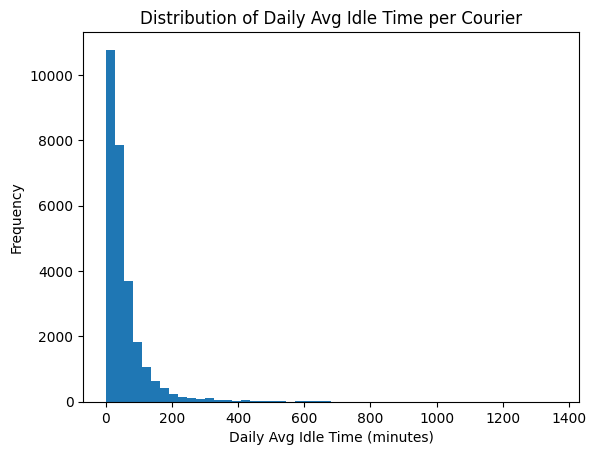

In [387]:
# Sort by courier + day + dispatch time
accepted_df = accepted_df.sort_values(["courier_id", "dt", "dispatch_time"])

# Idle = gap between end of previous trip and start of next, within the same day
accepted_df["prev_arrive"] = accepted_df.groupby(["courier_id", "dt"])["arrive_time"].shift()
accepted_df["idle_time"] = (
    (accepted_df["dispatch_time"] - accepted_df["prev_arrive"]).dt.total_seconds() / 60
)

# Drop NaNs and negatives
accepted_df = accepted_df[accepted_df["idle_time"].notna()]
accepted_df = accepted_df[accepted_df["idle_time"] >= 0]

# Daily avg idle time per courier
daily_idle = (
    accepted_df.groupby(["dt", "courier_id"])["idle_time"]
    .mean()
    .reset_index()
)

print(daily_idle["idle_time"].describe())

# Histogram across all couriers & days
daily_idle["idle_time"].plot(
    kind="hist", bins=50, title="Distribution of Daily Avg Idle Time per Courier"
)
plt.xlabel("Daily Avg Idle Time (minutes)")
plt.show()


## **Customer Fairness Analysis**

### Delay Analysis per area 

Zones with highest % of late orders:
da_id
5     17.122535
13    17.032806
0     16.476138
22    13.903743
9     13.841450
dtype: float64

Zones with lowest % of late orders:
da_id
10    6.632940
20    5.321220
3     4.959423
6     3.239741
18    2.193828
dtype: float64


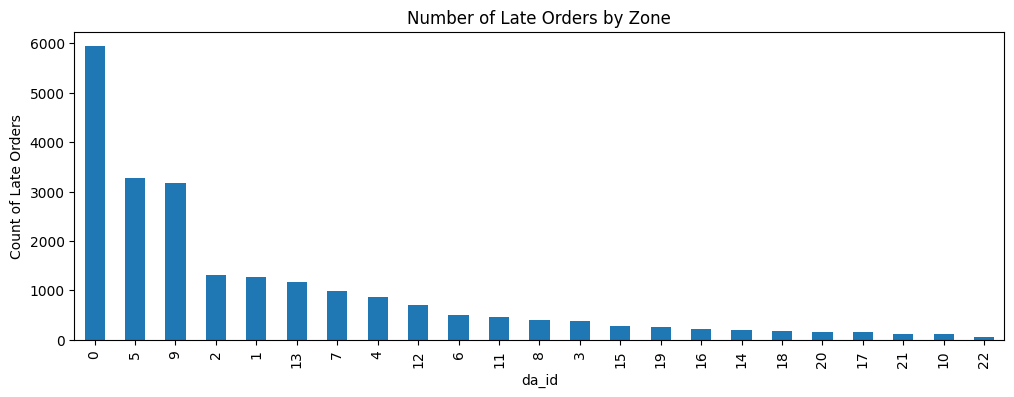

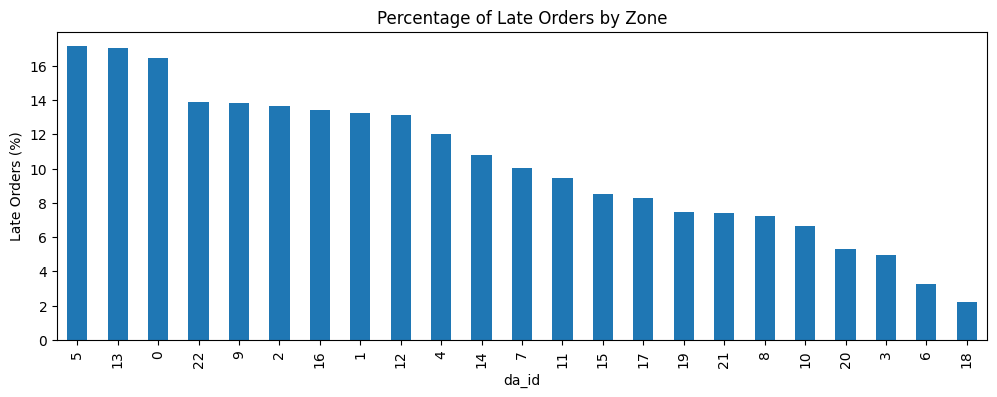

In [388]:
# --- 1. Compute actual service time in minutes ---
accepted_df["service_time"] = (
    (accepted_df["arrive_time"] - accepted_df["dispatch_time"]).dt.total_seconds() / 60
)

# --- 2. Compute estimated service time in minutes ---
accepted_df["estimated_service_time"] = (
    (accepted_df["estimate_arrived_time"] - accepted_df["dispatch_time"]).dt.total_seconds() / 60
)

# --- 3. Compute delay relative to estimate ---
accepted_df["delay_vs_estimate"] = accepted_df["service_time"] - accepted_df["estimated_service_time"]

# --- 4. Filter only late orders ---
late_orders = accepted_df[accepted_df["delay_vs_estimate"] > 0]

# --- 5. Count and percentage of late orders per zone ---
late_counts = late_orders.groupby("da_id").size()
total_orders = accepted_df.groupby("da_id").size()
late_percentage = (late_counts / total_orders * 100).sort_values(ascending=False)

print("Zones with highest % of late orders:")
print(late_percentage.head())

print("\nZones with lowest % of late orders:")
print(late_percentage.tail())

# --- 6. Visualize number of late orders ---
plt.figure(figsize=(12,4))
late_counts.sort_values(ascending=False).plot(kind="bar", title="Number of Late Orders by Zone")
plt.ylabel("Count of Late Orders")
plt.show()

# --- 7. Visualize percentage of late orders ---
plt.figure(figsize=(12,4))
late_percentage.plot(kind="bar", title="Percentage of Late Orders by Zone")
plt.ylabel("Late Orders (%)")
plt.show()


### Rejection rates per area 

Zones with highest rejection rate:
       total_assignments  rejected_orders  rejection_rate
da_id                                                    
0                 148903          33764.0       22.675164
5                  79796          17844.0       22.362023
2                  36434           7969.0       21.872427
12                 19212           3579.0       18.628982
13                 23102           4234.0       18.327418

Zones with lowest rejection rate:
       total_assignments  rejected_orders  rejection_rate
da_id                                                    
18                 21183              0.0             0.0
19                 11507              0.0             0.0
20                  7947              0.0             0.0
21                  5449              0.0             0.0
11                 17229              0.0             0.0


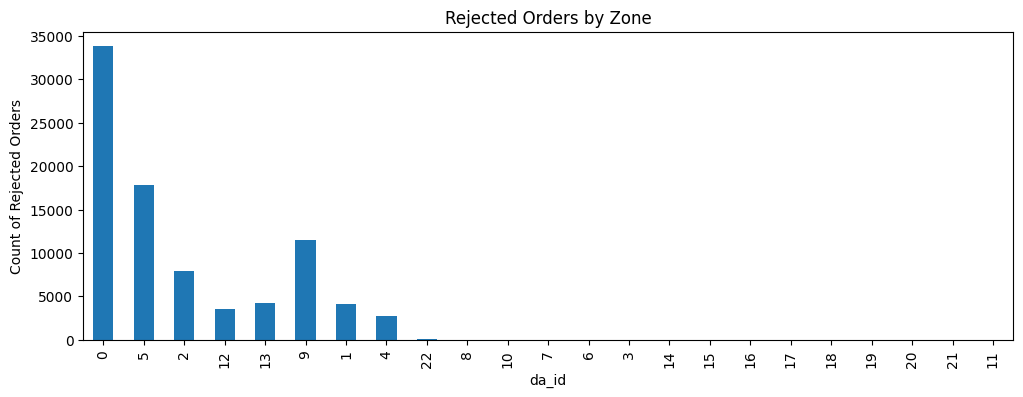

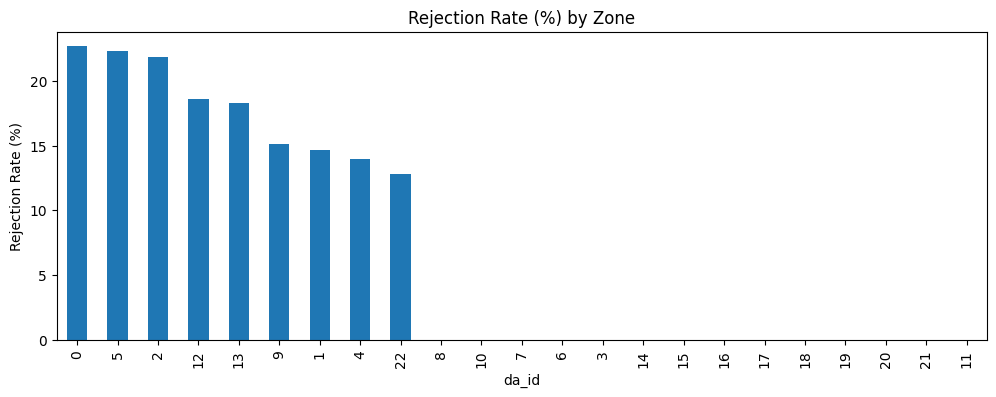

In [389]:
# --- 1. Count total assignmnets/dispatches per zone ---
zone_stats = df.groupby("da_id").size().to_frame("total_assignments")

# --- 2. Count rejected orders per zone (is_courier_grabbed == 0) ---
zone_stats["rejected_orders"] = df[df["is_courier_grabbed"] == 0].groupby("da_id").size()

# --- 3. Fill NaN (zones with 0 rejected) ---
zone_stats["rejected_orders"] = zone_stats["rejected_orders"].fillna(0)

# --- 4. Compute rejection percentage ---
zone_stats["rejection_rate"] = (zone_stats["rejected_orders"] / zone_stats["total_assignments"]) * 100

# --- 5. Sort by rejection rate ---
zone_stats = zone_stats.sort_values("rejection_rate", ascending=False)

print("Zones with highest rejection rate:")
print(zone_stats.head())

print("\nZones with lowest rejection rate:")
print(zone_stats.tail())

# --- 6. Plot rejected order counts ---
plt.figure(figsize=(12,4))
zone_stats["rejected_orders"].plot(kind="bar", title="Rejected Orders by Zone")
plt.ylabel("Count of Rejected Orders")
plt.show()

# --- 7. Plot rejection rate (%) ---
plt.figure(figsize=(12,4))
zone_stats["rejection_rate"].plot(kind="bar", title="Rejection Rate (%) by Zone")
plt.ylabel("Rejection Rate (%)")
plt.show()


**Comment:** Some zones, like zone 13, experience a high percentage of delays despite the absolute count of accepted being relatively low. From the second set of graphs we can see that again zone 13 has a relatively high rejection percentage and so it is one of the more underserviced areas as a whole..

## **Research Question**

#### **How can fairness-aware dispatch models be optimized to balance courier workload equity, spatiotemporal fairness, and service quality for customers while maintaining overall system efficiency?**

Efficiency here can be split into:

* Operational efficiency: minimizing delivery times, idle time, and detours.

* Resource efficiency: maximizing courier utilization i.e fewer wasted trips, less waiting/idle time etc.

* System throughput: serving more orders in less time.